# Ноутбук с минимальным решением задачи Titanic

In [41]:
# На основе https://jaketae.github.io/study/sklearn-pipeline/

## Загрузка библиотек

In [113]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import pickle

## EDA

In [114]:
np.random.seed(42)
train_data = pd.read_csv('../data/train.csv')
X, y = train_data.drop(columns=['Survived']), train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [115]:
X_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            137
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          552
Embarked         2
dtype: int64

In [116]:
X_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             40
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          135
Embarked         0
dtype: int64

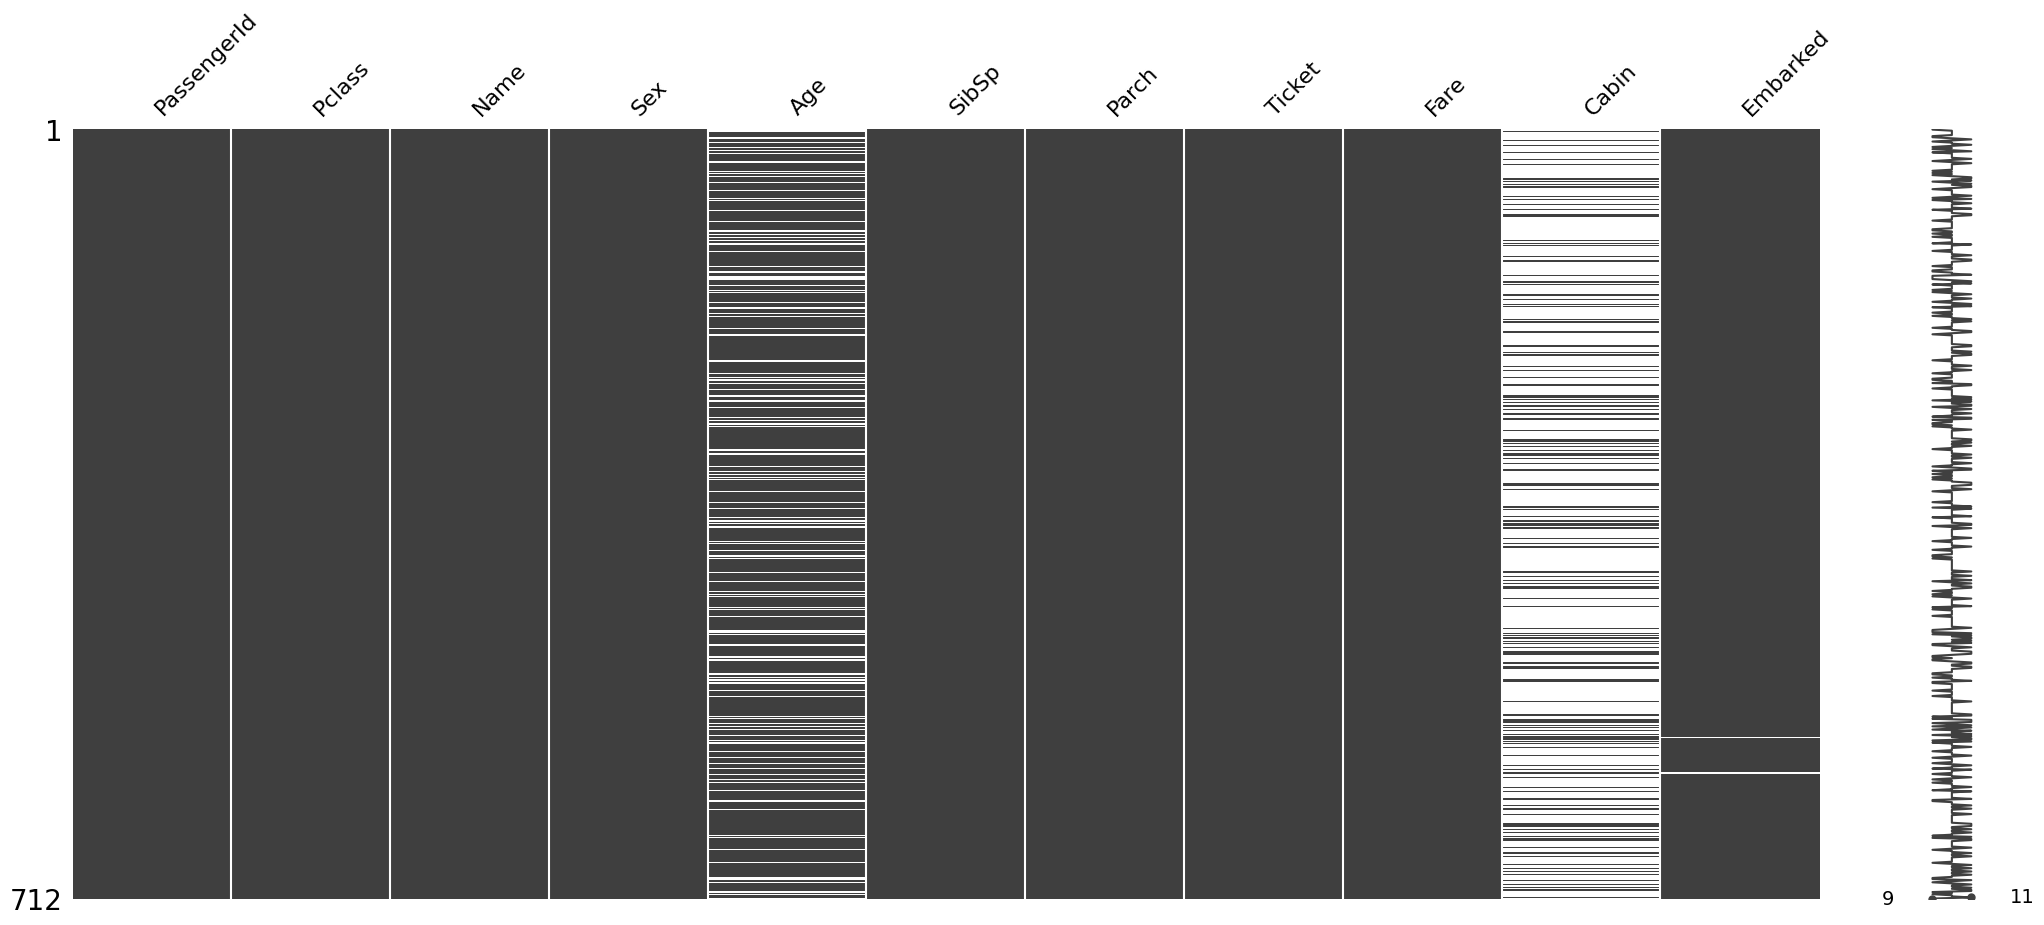

In [117]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

msno.matrix(X_train)
plt.show()

In [118]:
# Слишком много пропусков
X_train.drop(['Cabin'], axis=1, inplace=True)
X_test.drop(['Cabin'], axis=1, inplace=True)

# Слишком мало полезности
X_train.drop(['Ticket'], axis=1, inplace=True)
X_test.drop(['Ticket'], axis=1, inplace=True)

X_train.drop(['Name'], axis=1, inplace=True)
X_test.drop(['Name'], axis=1, inplace=True)

/tmp/ipykernel_123236/3886058482.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  g = sns.heatmap(X_comb[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']].corr(),


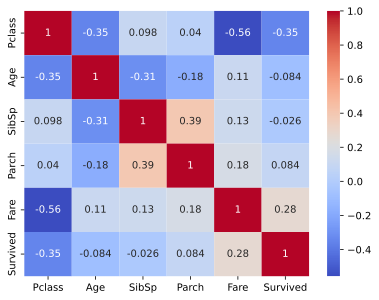

In [119]:
%config InlineBackend.figure_format = 'svg'

X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)
g = sns.heatmap(X_comb[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']].corr(),
                annot=True, 
                cmap = "coolwarm")


## Создание пайплайнов

In [120]:
def get_cat_cols(df):
  obj_cols = df.columns[df.dtypes == 'object']
  cat_cols = df.columns[df.dtypes == 'category']
  return set(obj_cols).union(set(cat_cols))

cat_cols = get_cat_cols(X_train)
cat_cols

{'Embarked', 'Sex'}

In [121]:
# Добавим еще pclass как категориальный признак
cat_cols = ['Embarked', 'Sex', 'Pclass']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(n_components=8))
])

In [122]:
num_cols = ['Age', 'Fare']
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

In [123]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [124]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

cross_val_score(clf, X_train, y_train, cv=10, scoring="accuracy").mean()

0.8089984350547731

## Подбор гиперпараметров

In [125]:
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 15)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 15))}

random_forest_dist = {'classifier__n_estimators': list(range(50, 500)),
                      'classifier__max_depth': list(range(2, 20)),
                      'classifier__bootstrap': [True, False]}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **random_forest_dist}

random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   n_jobs=-1,
                                   scoring="accuracy")

In [126]:
random_search.fit(X_train, y_train)


/home/dima/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
195 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dima/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dima/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/dima/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/hom

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Age',
                                                                                'Fare']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse=False)),
                                                                                               ('pca',
                                                                                                PCA(n_components=8))...
                                                                     77, 78, 79, ...],
                                        'preprocessor__cat__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__cat__pca__n_components': [2,
                                                                                 3,
                                                                                 4,
                                                                                 5,
                                                                                 6,
                                                                                 7,
                                                                                 8,
                                                                                 9,
                                                                                 10,
                                                                                 11,
                                                                                 12,
                                                                                 13,
                                                                                 14],
                                        'preprocessor__num__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__num__imputer__n_neighbors': [2,
                                                                                    3,
                                                                                    4,
                                                                                    5,
                                                                                    6,
                                                                                    7,
                                            

In [86]:
random_search.best_score_

0.8301487245149218

In [87]:
random_search.best_params_

{'preprocessor__num__imputer__n_neighbors': 13,
 'preprocessor__num__imputer__add_indicator': False,
 'preprocessor__cat__pca__n_components': 4,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__cat__imputer__add_indicator': False,
 'classifier__n_estimators': 167,
 'classifier__max_depth': 6,
 'classifier__bootstrap': True}

## Оценка качества

In [88]:
y_pred = random_search.predict(X_test)
y_pred[:5]

array([0, 0, 0, 0, 1])

In [92]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       110
           1       0.87      0.59      0.71        69

    accuracy                           0.81       179
   macro avg       0.83      0.77      0.78       179
weighted avg       0.82      0.81      0.80       179



/home/dima/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


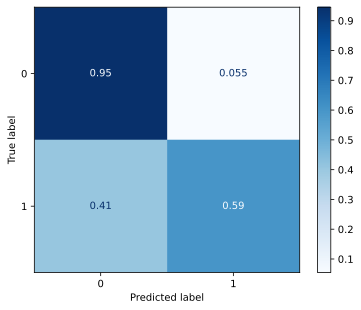

In [94]:
plot_confusion_matrix(random_search, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
plt.show()

## Сохранение модели

In [96]:
filename = 'serialized_model.sav'
pickle.dump(random_search, open(filename, 'wb'))

In [110]:
# Проверка
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8100558659217877


In [106]:
preds = loaded_model.predict(X_test.head(1))